### MAST30034: Applied Data Science Project 1
---
# Data Analysis: Modelling Average Trip Distance Over Time
#### Xavier Travers (1178369)

TODO: Modelling Average Trip Distance Over Time

In [1]:
# imports used throughout this notebook
from collections import defaultdict
from itertools import product
import os
import sys
from pyspark.sql import DataFrame, Column
from pyspark.sql.types import IntegerType
from pyspark.sql import functions as F
import geopandas

# add homemade helpers
sys.path.insert(1, '../scripts')
import helpers.join_helpers as jh
import helpers.plot_helpers as ph

# for printouts
DEBUGGING = False

In [2]:
from pyspark.sql import SparkSession

# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName('MAST30034 XT Project 1')
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config('spark.sql.repl.eagerEval.enabled', True) 
    .config('spark.sql.parquet.cacheMetadata', 'true')
    .config("spark.executor.memory", "2g")
    .config("spark.driver.memory", "4g")
    .getOrCreate()
)

22/08/14 02:58:26 WARN Utils: Your hostname, Polaris resolves to a loopback address: 127.0.1.1; using 172.26.235.73 instead (on interface eth0)
22/08/14 02:58:26 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/08/14 02:58:27 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/08/14 02:58:28 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/08/14 02:58:28 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
22/08/14 02:58:28 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.


### Grouped by Pick-Up Location

In [3]:
# read in the aggregated tlc by pickup data
tlc_pu_df = spark.read.parquet('../data/curated/tlc/aggregated/yellow/by_pu')
tlc_pu_df.limit(5)

week_year,week_month,week_ending,week_index,timeline,pu_borough,num_*,tot_passengers,daily_avg_passengers,avg_passengers,tot_trip_distance,daily_avg_trip_distance,avg_trip_distance,tot_hours_elapsed,daily_avg_hours_elapsed,avg_hours_elapsed
2020,5,2020-05-16,124,post,Brooklyn,986,1334.0,190.57142857142858,1.3529411764705883,3984.920000000005,569.2742857142864,4.041501014198788,316.52833333333365,45.218333333333376,0.32102265043948647
2021,1,2021-01-09,158,post,Staten Island,55,57.0,8.142857142857142,1.0363636363636364,1663.89,237.69857142857146,30.252545454545455,45.27888888888889,6.468412698412699,0.8232525252525253
2020,8,2020-08-15,137,post,Bronx,1263,1511.0,215.85714285714286,1.196357878068092,3173.2900000000004,453.3271428571429,2.5125019794140937,435.9388888888894,62.276984126984196,0.34516143221606443
2020,4,2020-05-02,122,post,Bronx,557,708.0,101.14285714285714,1.2710951526032317,2042.720000000001,291.817142857143,3.6673608617594273,173.4888888888888,24.78412698412697,0.3114701775384
2020,6,2020-06-06,127,post,Manhattan,78025,104586.0,14940.857142857143,1.340416533162448,191468.2500000006,27352.60714285723,2.453934636334516,15841.168611110981,2263.0240873015687,0.2030268325679075


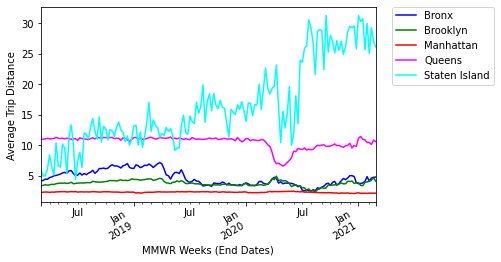

In [4]:
# generate a time series graph of daily avg trips vs week index.
ph.time_series(tlc_pu_df.toPandas(), 'avg_trip_distance', 'pu_borough', 
    ylabel = 'Average Trip Distance')

Note that there appears to be no data past March 2021.
This is likely due to 

### Grouped by Drop-Off Location

In [5]:
# read in the aggregated tlc by dropoff data
tlc_do_df = spark.read.parquet('../data/curated/tlc/aggregated/yellow/by_do')
tlc_do_df.limit(5)

week_year,week_month,week_ending,week_index,timeline,do_borough,num_*,tot_passengers,daily_avg_passengers,avg_passengers,tot_trip_distance,daily_avg_trip_distance,avg_trip_distance,tot_hours_elapsed,daily_avg_hours_elapsed,avg_hours_elapsed
2020,5,2020-05-16,124,post,Brooklyn,2568,3285.0,469.2857142857143,1.2792056074766356,16621.290000000037,2374.4700000000053,6.472464953271043,1246.650833333335,178.09297619047643,0.4854559319833859
2021,1,2021-01-09,158,post,Staten Island,143,179.0,25.571428571428573,1.2517482517482517,3290.739999999998,470.105714285714,23.01216783216782,102.42972222222225,14.632817460317465,0.716291763791764
2020,8,2020-08-15,137,post,Bronx,4116,5485.0,783.5714285714286,1.3326044703595723,26773.550000000017,3824.7928571428597,6.50474975704568,2086.3524999999977,298.0503571428568,0.5068883624878517
2020,4,2020-05-02,122,post,Bronx,1791,2324.0,332.0,1.2975991066443329,10743.660000000005,1534.8085714285721,5.998693467336686,596.366111111111,85.19515873015871,0.33297940318878333
2020,6,2020-06-06,127,post,Manhattan,73655,98780.0,14111.42857142857,1.3411173715294278,167662.5000000017,23951.785714285954,2.276322041952368,13765.52333333326,1966.5033333333229,0.18689190595795616


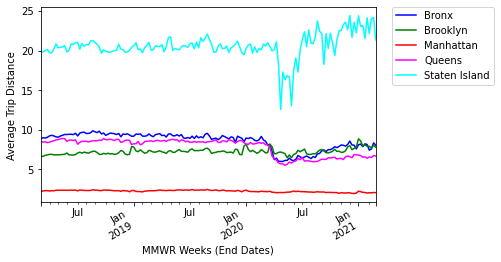

In [6]:
# generate a time series graph of daily avg trips vs week index.
ph.time_series(tlc_do_df.toPandas(), 'avg_trip_distance', 'do_borough', 
    ylabel = 'Average Trip Distance')